In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('data.xlsx')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We have some missed data on customer "id" and "description of product bought" features. If value of "product description" can be used for segmentation, customer id will not give any usefull information. We will set it to some default number.

In [4]:
df["Description"].fillna("No Description", inplace=True)
df["CustomerID"].fillna("-1", inplace=True)

In [5]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


We can see that we have some rows with negative Quantity and UnitPrice. It would be great to communicate with managers and understand why this values are negative. Imagine minus there to be a mistake and we will take abs of this numbers. 

In [7]:
df["Quantity"] = df["Quantity"].abs()
df["UnitPrice"] = df["UnitPrice"].abs()

Now our data looks much better.

# Feature Engineering


In this research I will work on **RFM** segmentation.

RFM segmentation is a method that helps you identify the most important types of customers by grouping them and giving scores to their Recency, Frequency, and Monetary values.

By using RFM Segmentation, you can identify your best customers, offer them personalised experiences, and provide them with relevant product recommendations. This will help increase their loyalty to your store, increasing their Customer Lifetime Value.

In [8]:
latest_date = df["InvoiceDate"].max()

g = df.groupby(["CustomerID"])
miliseconds_max = int(g["InvoiceDate"].max().max().to_pydatetime().strftime("%Y%m%d%H%M%S"))
miliseconds_min = int(g["InvoiceDate"].max().min().to_pydatetime().strftime("%Y%m%d%H%M%S"))

data = pd.DataFrame(columns=["Recency", "Frequency", "Monetary"])


for id in df["CustomerID"].unique():
    current_group = g.get_group(id) 
    millisecs = int(current_group["InvoiceDate"].max().to_pydatetime().strftime("%Y%m%d%H%M%S"))

    recency = (latest_date - current_group["InvoiceDate"].max()).days
    frequency = current_group.shape[0]
    monetary = sum(current_group["Quantity"] * current_group["UnitPrice"])
    
    data.loc[len(data.index)] = [recency, frequency, sum(current_group["Quantity"] * current_group["UnitPrice"])] 
    

Now our data has 3 columns (Recency, Frequency, Monetary)

In [9]:
data

,Recency,Frequency,Monetary
0,301.0,312.0,5493.79
1,31.0,196.0,3395.98
2,2.0,251.0,7375.42
3,95.0,28.0,948.25
4,329.0,6.0,1116.90
...,...,...,...
4368,1.0,12.0,196.89
4369,1.0,18.0,343.50
4370,0.0,2.0,360.00
4371,0.0,12.0,227.39


# Data Normalization

In [10]:
data = (data-np.min(data))/(np.max(data)-np.min(data))

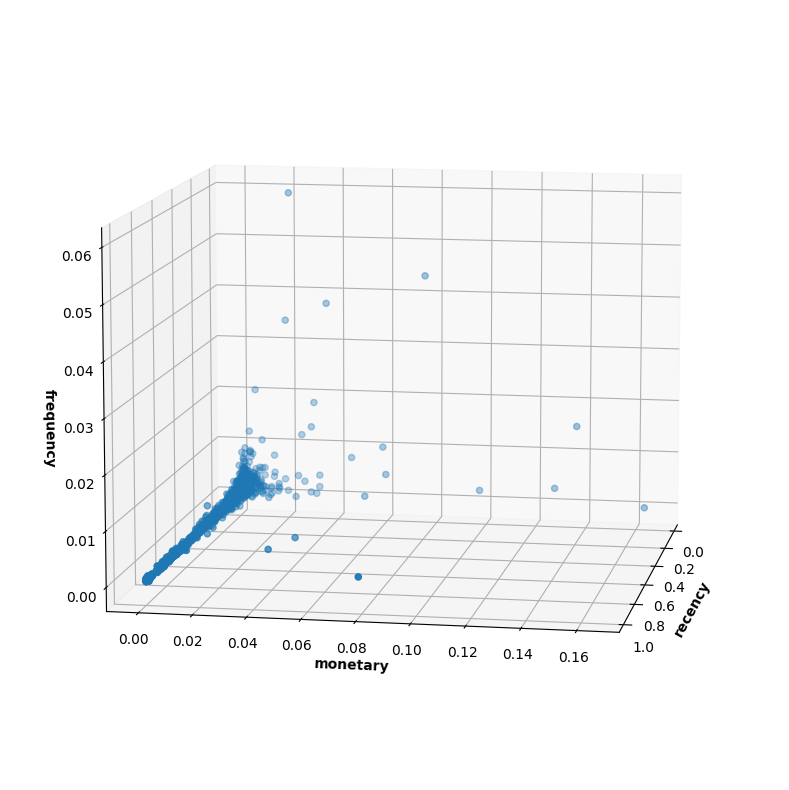

In [11]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection ="3d")
ax.view_init(10, 10)

data_1 = data[data.Frequency <= 0.9]
data_1 = data_1.reset_index()

ax.scatter3D(data_1["Recency"], data_1["Monetary"], data_1["Frequency"])
ax.set_xlabel('recency', fontweight ='bold')
ax.set_ylabel('monetary', fontweight ='bold')
ax.set_zlabel('frequency', fontweight ='bold')

plt.show()

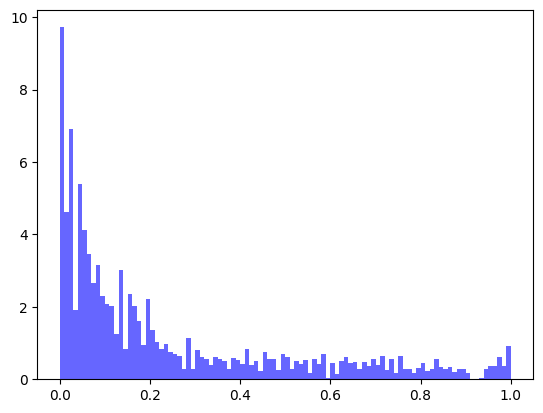

In [12]:
plt.hist(data["Recency"], bins=100, density=True, alpha=0.6, color='b')  
plt.show()

In [13]:
def print_clusters(clustered, data):
    unique_classes = len(np.unique(clustered.labels_))
    colors = ["red", "green", "blue", "yellow", "orange"]

    cluster_plot = pd.DataFrame()
    cluster_plot['data_index'] = data.index.values
    cluster_plot['cluster'] = clustered.labels_

    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection ="3d")
    ax.view_init(10, 10)
    ax.set_xlabel('recency', fontweight ='bold')
    ax.set_ylabel('monetary', fontweight ='bold')
    ax.set_zlabel('frequency', fontweight ='bold')

    for label, c in zip(np.unique(clustered.labels_), colors[:unique_classes]):
        print(label)
        indexes = list(cluster_plot[cluster_plot.cluster == label].data_index)
        values = data.iloc[indexes]
        ax.scatter3D(values["Recency"],values["Monetary"], values["Frequency"], color = c)

    plt.show()

# Creating models

In [14]:
clusters = 10
centroids_q = 30

inertia_list = []
for k in range(1, clusters):
    kmeans = KMeans(n_clusters=k, random_state=centroids_q, n_init = "auto").fit(data)
    inertia_list.append(kmeans.inertia_)

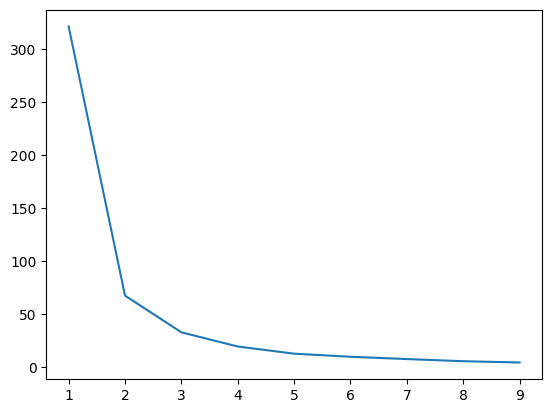

In [15]:
plt.plot(range(1, clusters), inertia_list)
plt.show()

From this image we can see that the best number of clusters is 3 or 4 (Elbow rule) But we can make some more tests by silhouette score. 

In [16]:
silhouette_list = []
for k in range(2, clusters):
    kmeans = KMeans(n_clusters=k, random_state=centroids_q, n_init = "auto").fit(data)
    silhouette_list.append(silhouette_score(data, kmeans.labels_, metric="euclidean"))

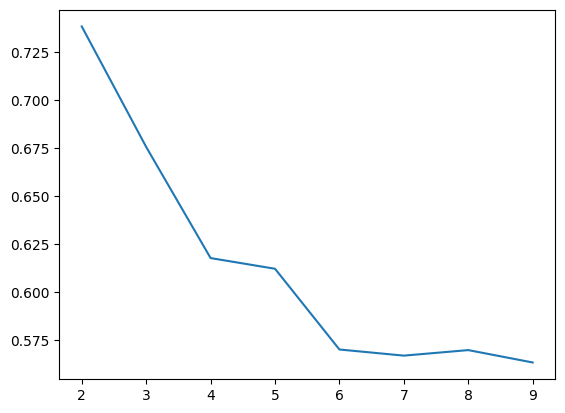

In [17]:
plt.plot(range(2, clusters), silhouette_list)
plt.show()

0
1
2
3


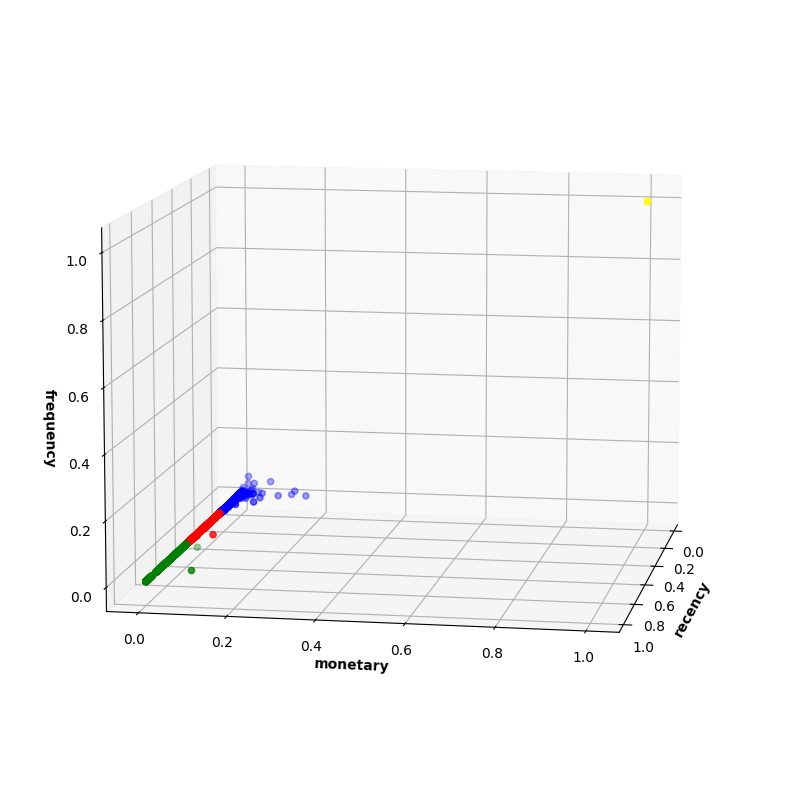

In [18]:
kmeans = KMeans(4, n_init = "auto").fit(data)
print_clusters(kmeans, data)

This graph proves that 3 clusters is optimal decision. 

# Gap Statistics

In [19]:
k = KMeans(4)
res = k.fit(data)

In [20]:
def euclidian_dis(coor_1, coor_2):
    return np.sqrt(sum((coor_1 - coor_2) ** 2))

def find_Wk(clustered, data):
    Wk = 0
    cluster_map = pd.DataFrame()
    cluster_map['data_index'] = data.index.values
    cluster_map['cluster'] = clustered.labels_

    for cluster_i in cluster_map['cluster'].unique():
        indexes = list(cluster_map[cluster_map.cluster == cluster_i].data_index)
        mean_data = np.mean(data.iloc[indexes])

        Wk += sum((np.linalg.norm(data.iloc[indexes] - mean_data, axis = 1)) ** 2)
        
    return Wk


<img src = "proof.png">

In [21]:
def find_k(data, nrefs = 20, maxClusters = 10, model_class = KMeans, additional_params = {}):
    s_k = None
    gaps = []
    s_k_list = []

    for cluster_i in range(1, maxClusters + 1):
        ref_disps = []
        for _ in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            model = model_class(cluster_i, **additional_params)
            res = model.fit(randomReference)
            ref_disps.append(find_Wk(res, pd.DataFrame(randomReference)))
        
        model = model_class(cluster_i, **additional_params)
        res = model.fit(data)
        orig_disp = find_Wk(res, data)
        if s_k is None:

            mean_ref = np.mean(np.log(ref_disps))
            std = np.sqrt(sum([(dist - mean_ref) ** 2 for dist in np.log(ref_disps)])/nrefs)
            s_k = std * np.sqrt(1 + 1/nrefs)
        else:
            s_k = s_k * np.sqrt(1 + 1/nrefs)

        s_k_list.append(s_k)
        
        d_of_k = np.log(np.mean(ref_disps)) - np.log(orig_disp)
        gaps.append(d_of_k)
    
    return range(1, maxClusters + 1), gaps, s_k_list 


Text(0.5, 1.0, 'Gap Statistic vs. K')

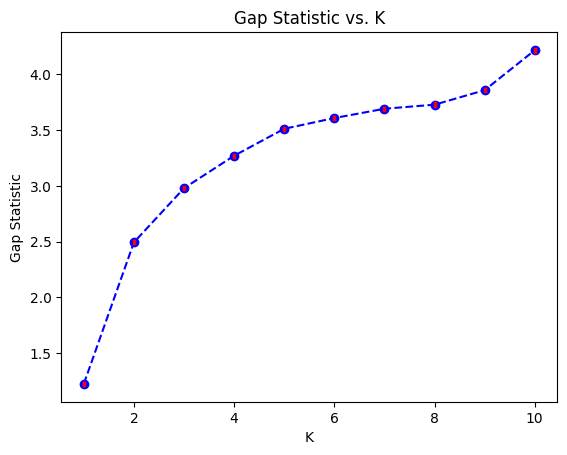

In [22]:
x, y, s_k_list = find_k(data, model_class=KMeans, additional_params = {"n_init":"auto"})
plt.plot(x, y, linestyle='--', marker='o', color='b')
for n_cluster, value, s_k in zip(x, y, s_k_list):
    plt.plot([n_cluster] * 2, [value - s_k, value + s_k], label = f"{n_cluster}", linewidth=2.5, color='r')
plt.xlabel('K')

plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs. K')


# Hierarchical Clustering

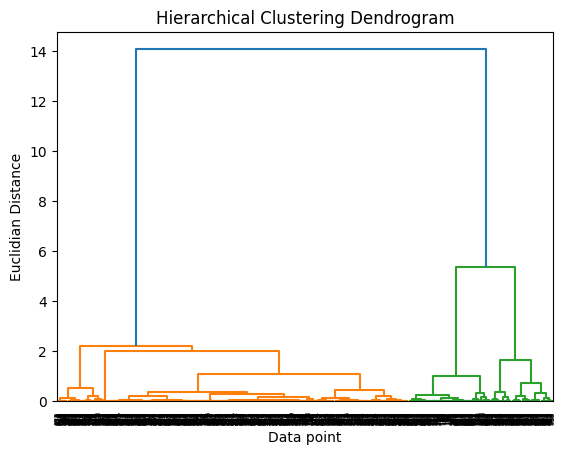

In [23]:
clustering = linkage(data[:1000], method = "ward")
 
dendrogram(clustering)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Euclidian Distance')
plt.show()

[0.007231626684910184, 0.007410212259807428, 0.007593208019155694, 0.007780722872797801, 0.00797286842011348, 0.008169759016437692, 0.008371511841119155, 0.008578246967259577, 0.008790087433175114, 0.009007159315622558]


Text(0.5, 1.0, 'Gap Statistic vs. K')

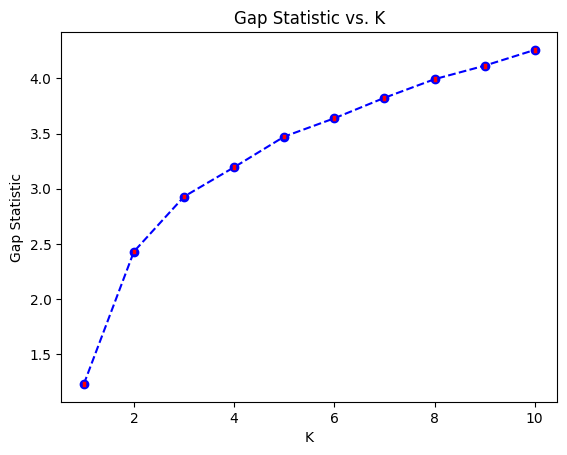

In [24]:
x, y, s_k_list = find_k(data, model_class=AgglomerativeClustering)
print(s_k_list)
plt.plot(x, y, linestyle='--', marker='o', color='b')
for n_cluster, value, s_k in zip(x, y, s_k_list):
    plt.plot([n_cluster] * 2, [value - s_k, value + s_k], label = f"{n_cluster}", linewidth=2.5, color='r')
plt.xlabel('K')

plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs. K')


0
1
2


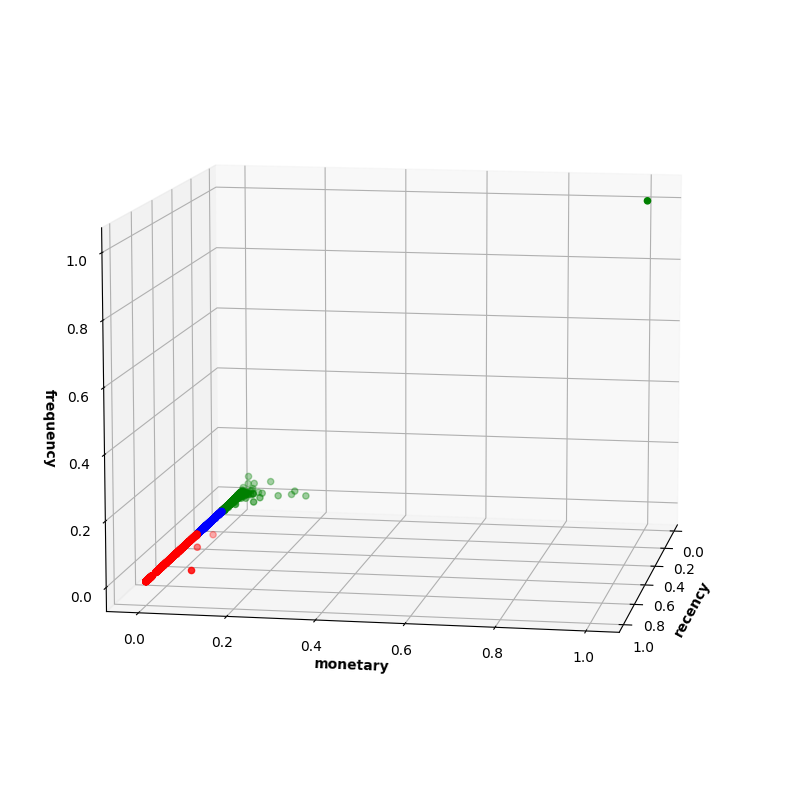

In [25]:
aglo_clust = AgglomerativeClustering(3).fit(data)
print_clusters(aglo_clust, data)

0
1
2


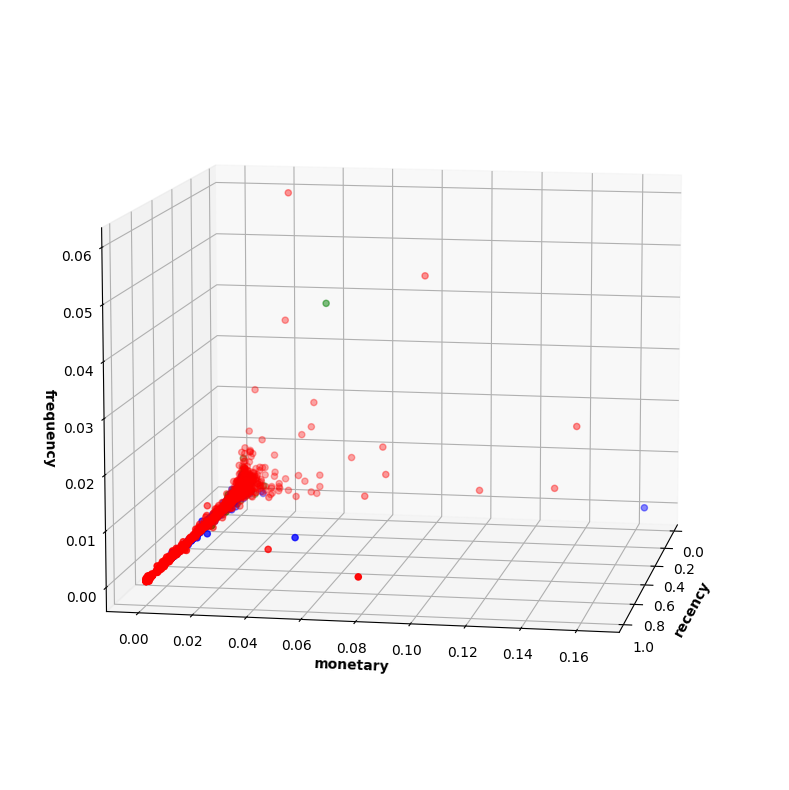

In [26]:
aglo_clust = AgglomerativeClustering(3).fit(data_1)
print_clusters(aglo_clust, data_1)

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [27]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)
print(distances)

[[0.00000000e+00 2.57081757e-03 2.93744193e-03 ... 4.12257845e-03
  4.17026759e-03 4.18983173e-03]
 [0.00000000e+00 4.18907795e-04 5.29216050e-04 ... 8.70499106e-04
  9.77518108e-04 1.06415877e-03]
 [0.00000000e+00 5.78692631e-04 7.08828571e-04 ... 1.02808407e-03
  1.08900429e-03 1.19218177e-03]
 ...
 [0.00000000e+00 8.45895732e-05 9.64230112e-05 ... 3.56533951e-04
  3.56790106e-04 3.66327420e-04]
 [0.00000000e+00 1.42426738e-05 6.24298770e-05 ... 3.27145185e-04
  3.40710024e-04 3.57377047e-04]
 [0.00000000e+00 3.88108882e-05 6.16416565e-05 ... 1.05432547e-04
  1.37245190e-04 1.41700133e-04]]


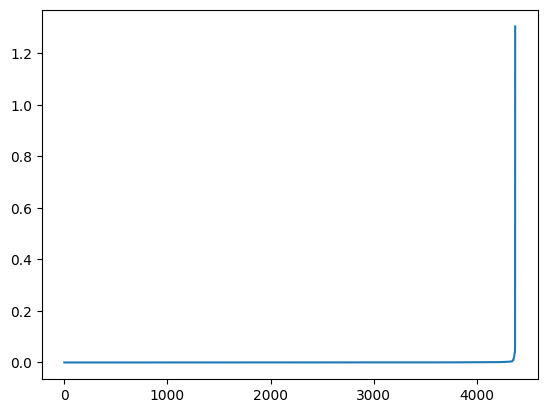

In [28]:
distances = np.sort(distances, axis=0)
distances_sorted = distances[:,1]
plt.plot(distances_sorted)

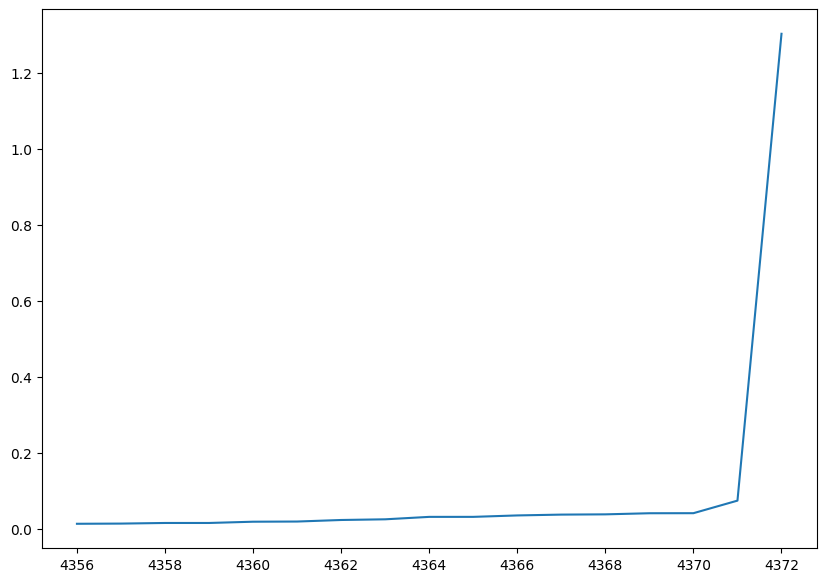

In [29]:
skip = 4356
# plt.fig_size()
fig = plt.figure(figsize=(10,7))
plt.plot(range(skip, len(distances_sorted)), distances_sorted[skip:])

In [30]:
eps = distances_sorted[4370] # 4371 (2 - 3 clusters)

dbscan = DBSCAN(eps=eps, min_samples=4)
# fitting model
model = dbscan.fit(data)
np.unique(model.labels_)


array([-1,  0,  1], dtype=int64)

-1
0
1


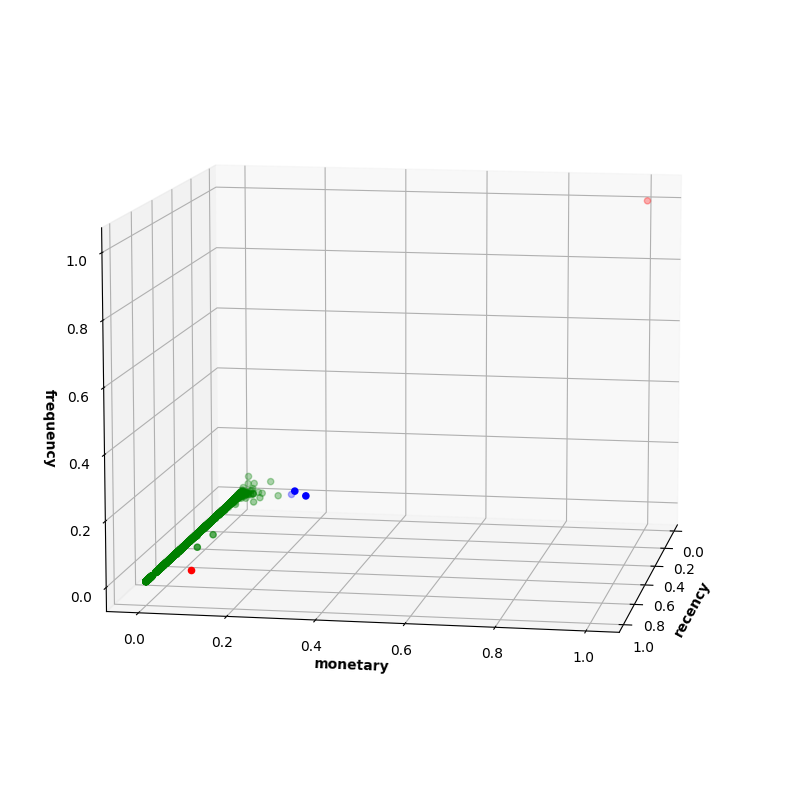

In [31]:
print_clusters(dbscan, data)

# Links
* https://hastie.su.domains/Papers/gap.pdf
* https://clevertap.com/blog/rfm-analysis/
* https://stats.stackexchange.com/questions/398635/relation-between-pairwise-distance-sum-and-sum-of-distance-to-mean-gap-statisti
